In [573]:
import pandas as pd
import os, sys, pickle
import ujson, re, itertools
import numpy as np
import seaborn as sns

from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from gensim.models import Word2Vec
from src.DataReader import DataReader
from src.constants import SPLIT_TIME, STORE_LOCATION, DATA_ROOT, POSTS_FILE, VOTES_FILE
from operator import itemgetter

In [3]:
%matplotlib inline

In [255]:
emb_root = '/Users/prmathur/Documents/Pers/MMDS/Course/CS224W/Project/snap-master/examples/node2vec/emb/'

In [256]:
ut_model = Word2Vec.load_word2vec_format(os.path.join(emb_root, 'ut_p1-q1.emb'), binary=False)

uu_model = Word2Vec.load_word2vec_format(os.path.join(emb_root, 'uu_p0.25-q0.25.emb'), binary=False)

In [257]:
indx2tag_dict = {}
tag2index_dict = {}
with open(os.path.join(STORE_LOCATION, 'graphs/user-tag_keys.txt')) as tg_fl:
    for row in tg_fl:
        k, v = row.strip().split(',')
        indx2tag_dict[float(v.strip())] = k
        tag2index_dict[k] = float(v.strip())

In [209]:
ut_comm = pd.read_csv(os.path.join(STORE_LOCATION, 'community_detection', 'user-tag-new-communityId.tsv'), '\t')

In [210]:
uu_comm = pd.read_csv(os.path.join(STORE_LOCATION, 'community_detection', 'user-user-new-communityId.tsv'), '\t')

In [211]:
def get_ut_comm(nid):
    comm = ut_comm[ut_comm.id==nid]['modularity_class'].values
    ret_vec = np.zeros(8)
    
    if comm.shape[0] > 0:
        ret_vec[comm[0]] = 1
        
    return ret_vec

In [212]:
uu_comm_cnts = uu_comm.groupby('modularity_class').count() > 2

In [213]:
big_comm = uu_comm_cnts[uu_comm_cnts.id==True].index.tolist()

In [214]:
uu_comm['modularity_class'][~uu_comm.modularity_class.isin(big_comm)] = -1

In [215]:
replace_dict = {'modularity_class': 
                dict(zip(uu_comm.modularity_class.unique(), 
                         np.arange(uu_comm.modularity_class.unique().shape[0]) + 10000))}

In [218]:
replace_dict['modularity_class'][-1] = -100

In [219]:
uu_comm = uu_comm.replace(replace_dict)

In [220]:
def get_uu_comm(nid):
    comm = uu_comm[uu_comm.id==nid]['modularity_class'].values
    ret_vec = np.zeros(58)
    
    if comm.shape[0] > 0 and comm[0] >= 10000:
        ret_vec[comm[0] - 10000] = 1
        
    return ret_vec

In [226]:
# get_uu_comm(80)

In [71]:
data_directory = DATA_ROOT

In [520]:
train_df = pd.read_csv(os.path.join(STORE_LOCATION, 'train.csv'))

In [521]:
test_df = pd.read_csv(os.path.join(STORE_LOCATION, 'test.csv'))

In [74]:
post_reader = DataReader(os.path.join(data_directory, POSTS_FILE), True)
post_reader.read_data()

Reading file...
Converting...
Progress | ██████████ | 100% || Estimated time remaining: 0.0 seconds
Conversion complete...
Forming data frame...


In [522]:
pdf = post_reader._df

q_tags_df = pdf[pdf.PostTypeId==1][['Id', 'Tags', 'Title', 'Body', 'FavoriteCount']]

train_df = train_df.merge(q_tags_df, how='left', left_on='QuestionId', right_on='Id', suffixes=('_tr', '_qt'))

test_df = test_df.merge(q_tags_df, how='left', left_on='QuestionId', right_on='Id', suffixes=('_tr', '_qt'))

In [523]:
train_df.FavoriteCount = train_df.FavoriteCount.fillna(0)
test_df.FavoriteCount = test_df.FavoriteCount.fillna(0)

In [524]:
def get_text_rep(train_df, test_df, field):
    vectorizer = TfidfVectorizer(min_df = 2)
    svd = TruncatedSVD(n_components=50)
    
    train_tfidf = vectorizer.fit_transform(train_df[field].values)
    train_tfidf_best = svd.fit_transform(train_tfidf)

    test_tfidf = vectorizer.transform(test_df[field].values)
    test_tfidf_best = svd.transform(test_tfidf)

    return train_tfidf_best, test_tfidf_best

In [525]:
train_body, test_body = get_text_rep(train_df, test_df, 'Body')

In [526]:
train_title, test_title = get_text_rep(train_df, test_df, 'Title')

In [527]:
train_df['body_repr'] = train_body.tolist()
test_df['body_repr'] = test_body.tolist()

In [528]:
train_df['title_repr'] = train_title.tolist()
test_df['title_repr'] = test_title.tolist()

In [529]:
train_df.FavoriteCount = train_df.FavoriteCount.astype(int)
test_df.FavoriteCount = test_df.FavoriteCount.astype(int)

In [530]:
train_df.head()

,QuestionId,AcceptedAnswerUserId,AnswerCreationDate,UsersSorted,UsersJaccard,Id,Tags,Title,Body,FavoriteCount,body_repr,title_repr
0,5.0,45.0,2010-07-20 19:21:52.240,"[45.0, 1102.0, 48.0, 226.0, 242.0]","{48.0: 0.5714285714285714, 242.0: 0.0135135135...",5,"[elementary-number-theory, proof-writing, radi...",How can you prove that the square root of two ...,<p>I have read a few proofs that $\sqrt{2}$ is...,14,"[0.181873417985, 0.0157658634759, 0.0066962837...","[0.324548922376, -0.188570008952, 0.1317489262..."
1,1.0,8.0,2010-07-20 19:22:20.193,"[8.0, 49.0, 25.0, 35.0, 39.0]","{8.0: 0.042253521126760563, 49.0: 0.5999999999...",1,"[elementary-set-theory, intuition, faq]",What Does it Really Mean to Have Different Kin...,<p>Can someone explain to me how there can be ...,32,"[0.185280055029, -0.0662526086788, -0.01167842...","[0.130584251032, -0.0644506331819, -0.02289859..."
2,8.0,38.0,2010-07-20 19:23:54.230,"[38.0, 173.0, 334.0, 53.0, 55.0]","{55.0: 0.44444444444444442, 334.0: 0.078431372...",8,"[linear-algebra, combinatorics, generating-fun...",How are we able to calculate specific numbers ...,<p>I was reading up on the Fibonacci Sequence ...,2,"[0.259041389642, -0.0571826219598, -0.01241225...","[0.192912027171, -0.0712689158065, 0.006061145..."
3,2.0,34.0,2010-07-20 19:24:52.200,"[34.0, 56.0, 35.0, 190287.0, 72.0]","{56.0: 0.071428571428571425, 72.0: 0.020689655...",2,"[calculus, limits, definition]",What is a Limit?,<p>This <em>limit</em> thing keeps coming up i...,9,"[0.140413551892, -0.0444013814394, -0.00881151...","[0.246496302139, -0.170203717123, 0.0607170295..."
4,20.0,38.0,2010-07-20 19:32:21.590,"[38.0, 72.0, 232.0, 51.0, 210.0]","{72.0: 0.020689655172413793, 232.0: 0.00612244...",20,"[terminology, definition, number-systems]","What is a real number (also rational, decimal,...",<p>In mathematics there seem to be a lot of di...,7,"[0.140666693718, -0.128020713251, 0.0593964169...","[0.0915691937887, -0.0968005346337, 0.06135534..."


In [531]:
itrain_df = train_df.copy()

In [532]:
val_df = train_df.iloc[11000:]
train_df = train_df.iloc[:11000]

In [307]:
def get_mrr(preds, Y):

    ranks = []
    for i in range(0, preds.shape[0] ,5):
        max_idx = np.argmax(Y[i:i+5])
        srt = np.argsort(preds[i:i+5],)[::-1]
        rank = np.where(srt==max_idx)[0][0] + 1

        ranks.append(rank)

    return np.mean(1. / np.array(ranks))

In [308]:
def get_accuracy(preds, Y):
    pr, tr = [], []
    for i in range(0, preds.shape[0] ,5):
        pr.append(np.argmax(preds[i:i+5]))
        tr.append(np.argmax(Y[i:i+5]))

    pr = np.array(pr)
    tr = np.array(tr)
    
    return (pr==tr).sum()* 1. / pr.shape[0] 

In [309]:
def get_user_vals(users):
    return re.findall(r'[{]*(\d+).0', users)

In [310]:
def get_rep(row):
    q_body = row.body_repr
    q_title = row.title_repr
    q_fav = row.FavoriteCount
    
    accepted_user = int(row.AcceptedAnswerUserId)

    outputs = []
    
    users = get_user_vals(row.UsersSorted)
    for u in users:
        user = int(u)
        op_row = None
        
        user_ut_comm = get_ut_comm(user)
        user_uu_comm = get_uu_comm(user)
        
        if user == accepted_user:
            op_row = np.hstack((q_body, q_title, q_fav, user_ut_comm, user_uu_comm, 1))
        else:
            op_row = np.hstack((q_body, q_title, q_fav, user_ut_comm, user_uu_comm, 0))
            
        outputs.append(op_row)

    outputs = np.vstack(outputs)

    return outputs

In [311]:
temp = get_rep(train_df.ix[0])

In [583]:
train_ds, val_ds = [], []
for indx, row in train_df.iterrows():
    temp_set = get_rep(row)
    train_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

train_ds = np.vstack(train_ds)

for indx, row in val_df.iterrows():
    temp_set = get_rep(row)
    val_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

val_ds = np.vstack(val_ds)

print '\nBegin train'

................
Begin train


In [332]:
clf = LogisticRegression(n_jobs=-1)
clf.fit(train_ds[:, :167], train_ds[:, 167])
preds = clf.predict_proba(val_ds[:, :167])[:, 1]
score = get_accuracy(preds, val_ds[:, 167])
mrr = get_mrr(preds, val_ds[:, 167])

................
Begin train


In [333]:
print 'Val scores'
print score, mrr

Val scores
0.482485404504 0.491395607451


In [335]:
preds = clf.predict_proba(train_ds[:, :167])[:, 1]
score = get_accuracy(preds, train_ds[:, 167])
mrr = get_mrr(preds, train_ds[:, 167])
print 'Train scores'
print score, mrr

Train scores
0.458909090909 0.501546969697


In [584]:
clf = GradientBoostingClassifier(verbose=3)
clf.fit(train_ds[:, :167], train_ds[:, 167])

      Iter       Train Loss   Remaining Time 
         1           0.9913           55.43s
         2           0.9835           52.66s
         3           0.9770           51.08s
         4           0.9717           51.50s
         5           0.9672           51.07s
         6           0.9634           50.18s
         7           0.9603           49.71s
         8           0.9577           48.87s
         9           0.9554           48.36s
        10           0.9535           47.74s
        11           0.9518           47.21s
        12           0.9504           46.90s
        13           0.9492           46.29s
        14           0.9481           45.68s
        15           0.9462           45.03s
        16           0.9446           44.49s
        17           0.9432           43.92s
        18           0.9422           43.30s
        19           0.9414           42.60s
        20           0.9406           41.63s
        21           0.9400           41.17s
        2

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=3, warm_start=False)

In [587]:
preds = clf.predict_proba(val_ds[:, :167])[:, 1]
score = get_accuracy(preds, val_ds[:, 167])
mrr = get_mrr(preds, val_ds[:, 167])
print 'Val scores'
print score, mrr

Val scores
0.490825688073 0.487878787879


In [588]:
preds = clf.predict_proba(train_ds[:, :167])[:, 1]
score = get_accuracy(preds, train_ds[:, 167])
mrr = get_mrr(preds, train_ds[:, 167])
print 'Train scores'
print score, mrr

Train scores
0.518181818182 0.523974242424


In [314]:
# test_ds = []
# for indx, row in test_df.iterrows():
#     temp_set = get_rep(row)
#     test_ds.append(temp_set)

#     if indx % 1000 == 0:
#         sys.stdout.write('.')
#         sys.stdout.flush()

# test_ds = np.vstack(test_ds)

In [315]:
# preds = clf.predict_proba(test_ds[:, :167])[:, 1]
# print get_accuracy(preds, test_ds[:, 167])
# print get_mrr(preds, test_ds[:, 167])

In [339]:
def get_rep_uu(row, ut_model, uu_model):
    tags = row.Tags
    tag_id = [str(int(tag2index_dict[t])) for t in tags if t in tag2index_dict]
    w2v_idx = [ut_model.vocab[t].index for t in tag_id if t in ut_model.vocab]
    t_vectors = ut_model.syn0[w2v_idx]
    q = t_vectors.mean(axis=0)
    
    q_body = row.body_repr
    q_title = row.title_repr
    q_fav = row.FavoriteCount
    
    accepted_user = int(row.AcceptedAnswerUserId)

    outputs = []
    
    users = get_user_vals(row.UsersSorted)
    for u in users:
        useri = int(u)
        user = str(useri)
        op_row = None
        
        if user in ut_model.vocab:
            user_w2v_idx = ut_model.vocab[user].index
            user_vector = ut_model.syn0[user_w2v_idx]
        else:
#             print user
            user_vector = np.zeros(128)
            
        if user in uu_model.vocab:
            user_uu_w2v_idx = uu_model.vocab[user].index
            user_uu_vector = uu_model.syn0[user_uu_w2v_idx]
        else:
#             print user, users
            user_uu_vector = np.zeros(128)
    
        user_ut_comm = get_ut_comm(useri)
        user_uu_comm = get_uu_comm(useri)
        
        if useri == accepted_user:
            op_row = np.hstack((q_body, q_title, q_fav, q, user_ut_comm, user_uu_comm, user_vector, user_uu_vector, 1))
        else:
            op_row = np.hstack((q_body, q_title, q_fav, q, user_ut_comm, user_uu_comm, user_vector, user_uu_vector, 0))
            
        outputs.append(op_row)

    outputs = np.vstack(outputs)

    return outputs

In [340]:
temp = get_rep_uu(train_df.ix[0], ut_model, uu_model)

In [534]:
train_ds, val_ds = [], []
for indx, row in train_df.iterrows():
    temp_set = get_rep_uu(row, ut_model, uu_model)
    train_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

train_ds = np.vstack(train_ds)

for indx, row in val_df.iterrows():
    temp_set = get_rep_uu(row, ut_model, uu_model)
    val_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

val_ds = np.vstack(val_ds)

print '\nBegin train'
max_c = train_ds.shape[1]-1

................
Begin train


In [539]:
itrain_ds = []

for indx, row in itrain_df.iterrows():
    temp_set = get_rep_uu(row, ut_model, uu_model)
    itrain_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

itrain_ds = np.vstack(itrain_ds)

................

In [535]:
clf = LogisticRegression(n_jobs=-1)
clf.fit(train_ds[:, :max_c], train_ds[:, max_c])
preds = clf.predict_proba(val_ds[:, :max_c])[:, 1]
score = get_accuracy(preds, val_ds[:, max_c])
mrr = get_mrr(preds, val_ds[:, max_c])

In [536]:
print 'Val scores'
print score, mrr

Val scores
0.396163469558 0.630904225744


In [537]:
preds = clf.predict_proba(train_ds[:, :max_c])[:, 1]
score = get_accuracy(preds, train_ds[:, max_c])
mrr = get_mrr(preds, train_ds[:, max_c])
print 'Train scores'
print score, mrr

Train scores
0.436909090909 0.658624242424


In [538]:
test_ds = []
for indx, row in test_df.iterrows():
    temp_set = get_rep_uu(row, ut_model, uu_model)
    test_ds.append(temp_set)

    if indx % 1000 == 0:
        sys.stdout.write('.')
        sys.stdout.flush()

test_ds = np.vstack(test_ds)

# preds = clf.predict_proba(test_ds[:, :max_c])[:, 1]
# print get_accuracy(preds, test_ds[:, max_c])
# print get_mrr(preds, test_ds[:, max_c])

.....

In [346]:
max_c

551

## RF

In [367]:
clf = RandomForestClassifier(n_jobs=-1, n_estimators=20, max_depth=10, oob_score=True, verbose=1)
clf.fit(train_ds[:, :max_c], train_ds[:, max_c])

print 'Val'
preds = clf.predict_proba(val_ds[:, :max_c])[:, 1]
print get_accuracy(preds, val_ds[:, max_c])
print get_mrr(preds, val_ds[:, max_c])

print 'Train'
preds = clf.predict_proba(train_ds[:, :max_c])[:, 1]
print get_accuracy(preds, train_ds[:, max_c])
print get_mrr(preds, train_ds[:, max_c])

print 'Test'
preds = clf.predict_proba(test_ds[:, :max_c])[:, 1]
print get_accuracy(preds, test_ds[:, max_c])
print get_mrr(preds, test_ds[:, max_c])

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.4s finished


Val
0.398040033361


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished


0.630490686683
Train


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished


0.583181818182
0.760683333333
Test
0.448625180897
0.672977970735


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished


## GBT

In [368]:
clf = GradientBoostingClassifier(verbose=3)
clf.fit(train_ds[:, :max_c], train_ds[:, max_c])

print 'Val'
preds = clf.predict_proba(val_ds[:, :max_c])[:, 1]
print get_accuracy(preds, val_ds[:, max_c])
print get_mrr(preds, val_ds[:, max_c])

print 'Train'
preds = clf.predict_proba(train_ds[:, :max_c])[:, 1]
print get_accuracy(preds, train_ds[:, max_c])
print get_mrr(preds, train_ds[:, max_c])

print 'Test'
preds = clf.predict_proba(test_ds[:, :max_c])[:, 1]
print get_accuracy(preds, test_ds[:, max_c])
print get_mrr(preds, test_ds[:, max_c])

      Iter       Train Loss   Remaining Time 
         1           0.9853            4.37m
         2           0.9723            4.35m
         3           0.9607            4.27m
         4           0.9513            4.19m
         5           0.9427            4.16m
         6           0.9354            4.11m
         7           0.9288            4.12m
         8           0.9230            4.08m
         9           0.9182            4.02m
        10           0.9136            3.99m
        11           0.9096            3.94m
        12           0.9063            3.90m
        13           0.9030            3.86m
        14           0.9001            3.81m
        15           0.8974            3.76m
        16           0.8949            3.70m
        17           0.8926            3.65m
        18           0.8906            3.60m
        19           0.8887            3.56m
        20           0.8868            3.52m
        21           0.8851            3.47m
        2

In [540]:
clf = GradientBoostingClassifier(verbose=3)
clf.fit(itrain_ds[:, :max_c], itrain_ds[:, max_c])

      Iter       Train Loss   Remaining Time 
         1           0.9852            6.32m
         2           0.9721            6.18m
         3           0.9612            6.06m
         4           0.9517            5.99m
         5           0.9437            5.86m
         6           0.9364            5.84m
         7           0.9303            5.78m
         8           0.9249            5.75m
         9           0.9199            5.72m
        10           0.9156            5.70m
        11           0.9116            5.65m
        12           0.9083            5.58m
        13           0.9051            5.50m
        14           0.9021            5.45m
        15           0.8997            5.40m
        16           0.8974            5.33m
        17           0.8952            5.24m
        18           0.8930            5.16m
        19           0.8910            5.11m
        20           0.8892            5.06m
        21           0.8874            5.00m
        2

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=3, warm_start=False)

In [542]:
print 'Test'
preds = clf.predict_proba(test_ds[:, :max_c])[:, 1]
print get_accuracy(preds, test_ds[:, max_c])
print get_mrr(preds, test_ds[:, max_c])

Test
0.480704293295
0.689922013185


In [577]:
# sns.set()

# 1993+1130

# 626+287+110

# 3123/4126.

In [543]:
def get_ranks(preds, Y):

    ranks = []
    for i in range(0, preds.shape[0] ,5):
        max_idx = np.argmax(Y[i:i+5])
        srt = np.argsort(preds[i:i+5],)[::-1]
        rank = np.where(srt==max_idx)[0][0] + 1

        ranks.append(rank)
        
    return ranks

ranks = np.array(get_ranks(preds, test_ds[:, max_c]))

plt.hist(ranks)
# plt.title('Rank distribution for test set')

In [546]:
good_questn = np.nonzero(ranks < 3)

bad_questn = np.nonzero(ranks > 3)

# test_df.iloc[bad_questn]

bad_questn_tags = test_df.iloc[bad_questn].Tags.values

tag_cnts = Counter(itertools.chain.from_iterable(bad_questn_tags))

with open('data_temp/tag_clusters.pkl', 'rb') as f:
    tag_clusters = pickle.load(f)

tag_comm_size = {l:len(v) for k,v in tag_clusters.items() for l in v}

tag_comm_size.get('3d', -1)

cnt, size = zip(*[(v, tag_comm_size.get(k, -1)) for k, v in tag_cnts.items()])

plt.scatter(cnt, size)

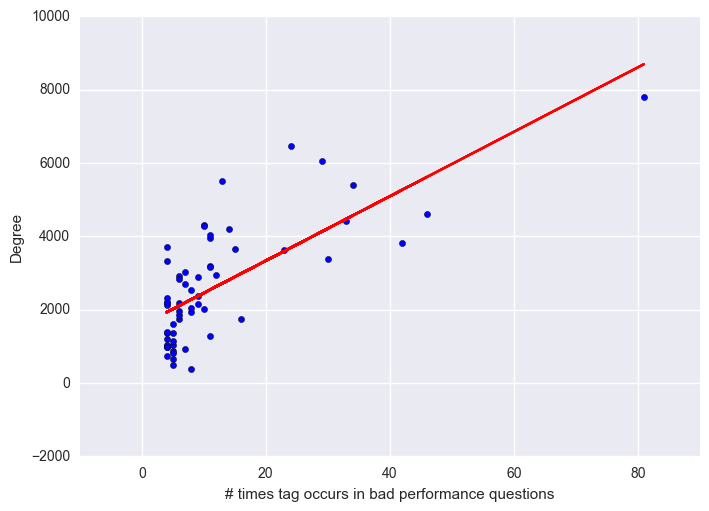

In [600]:
degrees = defaultdict(int)
with open('data_created/graphs/user-tag.txt', 'r') as fl:
    for line in fl.readlines():
        n1, n2 = line.split('\t')
        degrees[float(n1)] += 1
        degrees[float(n2)] += 1



cnt_degrees = [(v, degrees[tag2index_dict[k]]) for k, v in tag_cnts.items() if k in tag2index_dict]

cnt_degrees_rel = filter(lambda x: x[0] > 3, cnt_degrees)
cnt, degree = zip(*cnt_degrees_rel)

slope, c = np.polyfit(cnt, degree, 1)
yfit = np.array(cnt) * slope + c

plt.plot(cnt, yfit, c='r')
plt.scatter(cnt, degree)


# plt.title('Tag count vs. Degree')
plt.ylabel('Degree')
plt.xlabel('# times tag occurs in bad performance questions')

In [602]:
bad_q_acc_users = test_df.iloc[bad_questn]['AcceptedAnswerUserId'].values

good_q_acc_users = test_df.iloc[good_questn]['AcceptedAnswerUserId'].values

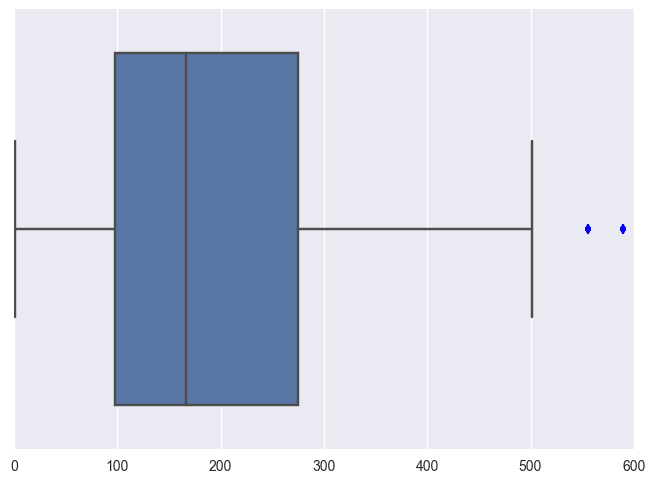

In [604]:
sns.boxplot(x=[degrees[u] for u in good_q_acc_users])

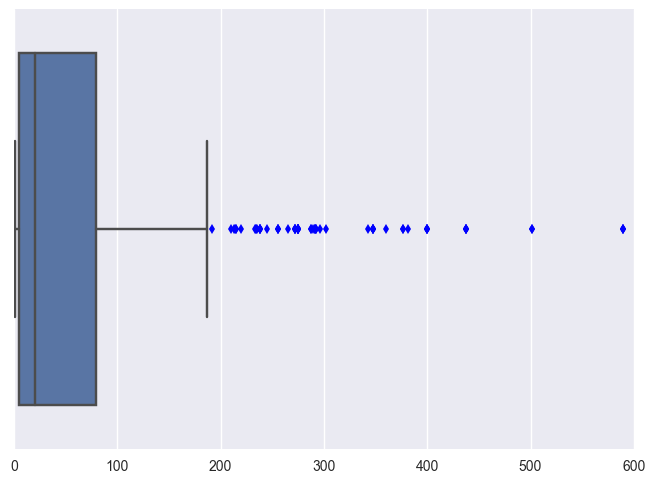

In [603]:
sns.boxplot(x=[degrees[u] for u in bad_q_acc_users])